In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import os
from joblib import dump

In [4]:
final_df = pd.read_csv('acdf_cleaned.csv')
final_df = final_df[final_df['AC50'] < 10000]

In [5]:
max(final_df['AC50'])

1190.0

In [6]:
final_df.dropna(inplace=True)
# final_df.T.dropna(inplace=True)
final_df.drop_duplicates(inplace=True)
final_df = final_df.T.drop_duplicates().T
final_df = final_df.T.dropna().T

In [7]:
col_names = final_df.columns.tolist()

In [8]:
temp = []
for i in range(0, len(final_df.columns)):
    if final_df[col_names[i]].nunique() < 10:
        temp.append(col_names[i])
    else:
        pass    

In [9]:
final_df.drop(columns=temp, inplace=True)

In [10]:

# Compute the correlation matrix
corr_matrix = final_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
final_df = final_df.drop(final_df[to_drop], axis=1)

In [11]:
from scipy.stats import shapiro
import pandas as pd

# Create an empty DataFrame to store the results
stats, p = [], []
# Assuming that `final_df` is a DataFrame
for column in final_df.columns:
    statistic, p_value = shapiro(final_df[column])
    # Append the results to the results DataFrame
    stats.append(statistic)
    p.append(p_value)
# Print the results DataFrame
p_df = pd.DataFrame({'Column': final_df.columns, 'Statistic': stats, 'p-value': p})

In [12]:
p_df = p_df[p_df['p-value'] > 0.05]

In [13]:
p_df.sort_values(by='p-value', ascending=False, inplace=True)
p_df

,Column,Statistic,p-value
82,GATS3c,0.994589,0.967165
12,AATS0v,0.992713,0.881312
225,AMW,0.991944,0.831274
198,ETA_dEpsilon_B,0.990464,0.720999
51,ATSC7v,0.990242,0.703647
...,...,...,...
99,GATS7e,0.974980,0.060516
196,ETA_AlphaP,0.974946,0.060156
102,GATS5i,0.974208,0.052850
69,ATSC4i,0.974138,0.052206


In [14]:
col_names = p_df['Column'].tolist()

In [15]:
col_names.remove('AC50_log')

In [16]:
normalize_df = pd.read_csv('acdf_cleaned.csv', usecols=col_names + ['AC50'])
normalize_df

,AMR,ATS6s,AATS6m,AATS7m,AATS8m,AATS0v,AATS5v,AATS6v,AATS8v,AATS6p,...,TDB8e,TDB9e,TDB10e,PPSA-1,PPSA-3,DPSA-1,FPSA-3,Du,E3m,AC50
0,54.1603,228.877315,62.096824,65.982053,61.423930,246.020315,183.601013,192.935061,169.591950,1.428454,...,47.183254,53.586954,58.087568,385.332309,18.102485,82.876531,0.026320,1.309972,0.181561,1190.0
1,51.4622,24.904321,62.114479,65.649784,67.532721,255.167393,190.386501,181.923574,195.374379,1.360939,...,60.656297,69.376688,77.592298,469.050681,26.657763,220.957792,0.037172,1.422600,0.245171,1140.0
2,22.8452,213.888889,71.245708,74.376173,70.629692,262.966871,205.578600,208.378578,215.607269,1.471832,...,58.896544,65.068621,69.951583,430.229987,23.057339,182.081343,0.033989,1.426697,0.143930,1030.0
3,45.8466,23.527778,55.212794,57.174031,59.727384,243.345213,179.938039,174.274802,188.822317,1.296010,...,60.427068,68.790522,76.973462,486.846952,27.173210,262.228281,0.038193,1.415445,0.221797,1000.0
4,58.4512,449.955247,78.389654,71.263536,75.022236,235.315912,175.644061,178.841071,167.008633,1.318572,...,54.157099,59.053209,58.120319,452.602381,22.560876,227.010021,0.033266,1.272207,0.209074,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,35.7083,304.416667,77.655411,67.505082,77.617845,259.335479,195.620645,203.707664,213.196501,1.382874,...,59.427375,62.570470,68.308513,380.689198,20.385711,179.389579,0.035028,1.313951,0.243418,16.0
93,74.6512,521.016461,84.289515,80.340653,80.058681,264.468053,212.835103,199.623683,177.596435,1.466116,...,55.538316,62.113517,64.054205,475.150279,25.306423,86.971581,0.029313,1.320353,0.126582,14.0
94,40.1848,318.194444,77.785229,65.071143,62.124289,251.840042,190.549827,208.062639,175.027237,1.414844,...,56.481556,62.974123,67.391812,412.182388,18.593432,211.988438,0.030363,1.269191,0.184499,11.0
95,44.6556,582.861111,73.287510,70.651487,55.891666,223.235141,193.623676,180.697161,151.340764,1.247007,...,55.275756,62.792771,80.334419,381.129807,26.915241,56.387604,0.038130,1.216235,0.194689,11.0


In [17]:
x = normalize_df.drop(columns=['AC50'])
y = normalize_df['AC50']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
x_train

,AMR,ATS6s,AATS6m,AATS7m,AATS8m,AATS0v,AATS5v,AATS6v,AATS8v,AATS6p,...,TDB6e,TDB8e,TDB9e,TDB10e,PPSA-1,PPSA-3,DPSA-1,FPSA-3,Du,E3m
49,41.2756,318.972222,73.490772,58.416930,55.976995,241.071442,185.159834,201.557369,162.277936,1.390021,...,45.748875,56.599376,63.560022,66.983395,440.070896,22.276273,260.170349,0.035931,1.305291,0.193005
70,41.4028,336.027778,78.631123,72.641381,73.541955,250.953810,198.179819,201.725987,201.780245,1.357963,...,45.694454,59.401220,62.007734,72.337902,429.374722,21.901366,227.681610,0.034705,1.206398,0.205487
68,34.3102,161.555556,61.574796,75.172733,60.814357,245.127978,167.563349,188.611958,184.344967,1.371584,...,42.240982,56.611031,62.380021,64.774102,366.711107,14.461677,160.795049,0.025255,1.319753,0.025606
15,53.7946,281.288580,78.082795,68.727400,74.173580,234.302556,171.727932,174.973454,170.113920,1.360192,...,44.213202,59.370477,65.142148,69.008617,497.147089,24.524367,263.158814,0.033543,1.417953,0.237873
39,50.3491,362.969136,86.813471,69.930103,91.339690,245.105394,177.235882,185.305606,178.512845,1.340852,...,42.929376,56.150812,65.361131,67.185404,399.991765,21.043534,152.599100,0.032505,1.335077,0.149878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,38.2247,288.416667,67.822998,54.262930,53.757790,241.688459,184.755719,196.657818,167.981951,1.393475,...,44.917052,55.962396,62.387595,64.929925,455.152504,18.661787,300.530251,0.030604,1.287919,0.211964
71,44.6220,386.154321,86.249274,70.430672,107.316730,249.175352,183.146848,187.805955,169.996437,1.318867,...,42.868627,53.595552,70.522092,68.121586,351.688698,19.851150,101.395181,0.032976,1.226873,0.116547
14,40.7090,238.416667,65.980689,57.912233,82.042138,248.986472,183.938579,194.537490,213.039471,1.383616,...,45.279878,61.096073,66.439147,73.193384,415.156822,31.258461,133.164046,0.044838,1.305478,0.277384
92,35.7083,304.416667,77.655411,67.505082,77.617845,259.335479,195.620645,203.707664,213.196501,1.382874,...,45.622699,59.427375,62.570470,68.308513,380.689198,20.385711,179.389579,0.035028,1.313951,0.243418


In [17]:
# scaler = StandardScaler()
# x = scaler.fit_transform(x)
# x = pd.DataFrame(x, columns=cols)
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
# import statsmodels.api as sm

# # Assuming that X is your matrix of predictors and y is your response variable
# # Add a constant to the predictors matrix
# x_train = sm.add_constant(x_train)

# # Fit the model
# model = sm.OLS(y_train, x_train)
# results = model.fit()

# # Print the summary of the model, which includes the hypothesis test results for each predictor
# print(results.summary())

In [19]:
# results.pvalues[results.pvalues < 0.05]

In [20]:
# final_df.to_csv('acdf_model8_regressor.csv', index=False)

In [19]:
# Create a Linear Regression model
dt = RandomForestRegressor()

# Fit the model
dt.fit(x_train, y_train)

# Get feature importances
importances = dt.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(np.abs(importances))[::-1]

# Get the names of the features sorted by importance
feature_names = x.columns[indices]

print('Features sorted by importance:')
print(feature_names)
feature_names = list(feature_names)

Features sorted by importance:
Index(['MATS5s', 'AATS5i', 'JGI3', 'ATS6s', 'JGI10', 'Du', 'ATSC3v', 'ATSC4i',
       'BCUTp-1l', 'SwHBa', 'GATS4c', 'TDB10e', 'AMR', 'AATS2i', 'GATS7e',
       'PPSA-1', 'FPSA-3', 'GATS7c', 'ATSC2p', 'ATSC5v', 'JGI9', 'TDB9e',
       'GATS2e', 'ATSC3p', 'GATS6i', 'GATS8m', 'GATS6m', 'GATS5s', 'AATS0v',
       'AATS6m', 'TDB6e', 'GATS8s', 'ATSC5p', 'AATS7i', 'GATS8c', 'TDB2u',
       'AATS5v', 'MIC1', 'ATSC6v', 'ATSC3i', 'ASP-0', 'AATS6p', 'GATS5m',
       'GATS7m', 'ATSC6p', 'GATS3c', 'AATS8v', 'AATS7m', 'TDB1u', 'E3m',
       'TDB8e', 'DPSA-1', 'SpMin4_Bhm', 'TDB5e', 'PPSA-3', 'ATSC1e', 'GATS3v',
       'GATS5i', 'GATS6c', 'TDB10m', 'ATSC5m', 'AATS3i', 'ETA_dEpsilon_B',
       'SaasC', 'AMW', 'ATSC7v', 'ATSC5c', 'XLogP', 'AATS8m', 'AATS6v',
       'ETA_AlphaP'],
      dtype='object')


In [23]:
feature_names 

['MATS5s',
 'AATS5i',
 'JGI3',
 'ATS6s',
 'JGI10',
 'Du',
 'ATSC3v',
 'ATSC4i',
 'BCUTp-1l',
 'SwHBa',
 'GATS4c',
 'TDB10e',
 'AMR',
 'AATS2i',
 'GATS7e',
 'PPSA-1',
 'FPSA-3',
 'GATS7c',
 'ATSC2p',
 'ATSC5v',
 'JGI9',
 'TDB9e',
 'GATS2e',
 'ATSC3p',
 'GATS6i',
 'GATS8m',
 'GATS6m',
 'GATS5s',
 'AATS0v',
 'AATS6m',
 'TDB6e',
 'GATS8s',
 'ATSC5p',
 'AATS7i',
 'GATS8c',
 'TDB2u',
 'AATS5v',
 'MIC1',
 'ATSC6v',
 'ATSC3i',
 'ASP-0',
 'AATS6p',
 'GATS5m',
 'GATS7m',
 'ATSC6p',
 'GATS3c',
 'AATS8v',
 'AATS7m',
 'TDB1u',
 'E3m',
 'TDB8e',
 'DPSA-1',
 'SpMin4_Bhm',
 'TDB5e',
 'PPSA-3',
 'ATSC1e',
 'GATS3v',
 'GATS5i',
 'GATS6c',
 'TDB10m',
 'ATSC5m',
 'AATS3i',
 'ETA_dEpsilon_B',
 'SaasC',
 'AMW',
 'ATSC7v',
 'ATSC5c',
 'XLogP',
 'AATS8m',
 'AATS6v',
 'ETA_AlphaP']

In [20]:
test = pd.read_csv('acdf_cleaned.csv', usecols=feature_names + ['AC50'])
test

,AMR,ATS6s,AATS6m,AATS7m,AATS8m,AATS0v,AATS5v,AATS6v,AATS8v,AATS6p,...,TDB8e,TDB9e,TDB10e,PPSA-1,PPSA-3,DPSA-1,FPSA-3,Du,E3m,AC50
0,54.1603,228.877315,62.096824,65.982053,61.423930,246.020315,183.601013,192.935061,169.591950,1.428454,...,47.183254,53.586954,58.087568,385.332309,18.102485,82.876531,0.026320,1.309972,0.181561,1190.0
1,51.4622,24.904321,62.114479,65.649784,67.532721,255.167393,190.386501,181.923574,195.374379,1.360939,...,60.656297,69.376688,77.592298,469.050681,26.657763,220.957792,0.037172,1.422600,0.245171,1140.0
2,22.8452,213.888889,71.245708,74.376173,70.629692,262.966871,205.578600,208.378578,215.607269,1.471832,...,58.896544,65.068621,69.951583,430.229987,23.057339,182.081343,0.033989,1.426697,0.143930,1030.0
3,45.8466,23.527778,55.212794,57.174031,59.727384,243.345213,179.938039,174.274802,188.822317,1.296010,...,60.427068,68.790522,76.973462,486.846952,27.173210,262.228281,0.038193,1.415445,0.221797,1000.0
4,58.4512,449.955247,78.389654,71.263536,75.022236,235.315912,175.644061,178.841071,167.008633,1.318572,...,54.157099,59.053209,58.120319,452.602381,22.560876,227.010021,0.033266,1.272207,0.209074,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,35.7083,304.416667,77.655411,67.505082,77.617845,259.335479,195.620645,203.707664,213.196501,1.382874,...,59.427375,62.570470,68.308513,380.689198,20.385711,179.389579,0.035028,1.313951,0.243418,16.0
93,74.6512,521.016461,84.289515,80.340653,80.058681,264.468053,212.835103,199.623683,177.596435,1.466116,...,55.538316,62.113517,64.054205,475.150279,25.306423,86.971581,0.029313,1.320353,0.126582,14.0
94,40.1848,318.194444,77.785229,65.071143,62.124289,251.840042,190.549827,208.062639,175.027237,1.414844,...,56.481556,62.974123,67.391812,412.182388,18.593432,211.988438,0.030363,1.269191,0.184499,11.0
95,44.6556,582.861111,73.287510,70.651487,55.891666,223.235141,193.623676,180.697161,151.340764,1.247007,...,55.275756,62.792771,80.334419,381.129807,26.915241,56.387604,0.038130,1.216235,0.194689,11.0


1 0.45
2 0.65
3 0.65
4 0.7
5 0.7
6 0.55
7 0.6
8 0.6
9 0.65
10 0.55
11 0.65
12 0.6
13 0.7
14 0.65
15 0.75
16 0.7
17 0.65
18 0.7
19 0.6
20 0.65
21 0.7
22 0.7
23 0.75
24 0.7
25 0.75
26 0.6
27 0.75
28 0.6
29 0.7
30 0.65
31 0.6
32 0.65
33 0.7
34 0.75
35 0.75
36 0.65
37 0.65
38 0.65
39 0.75


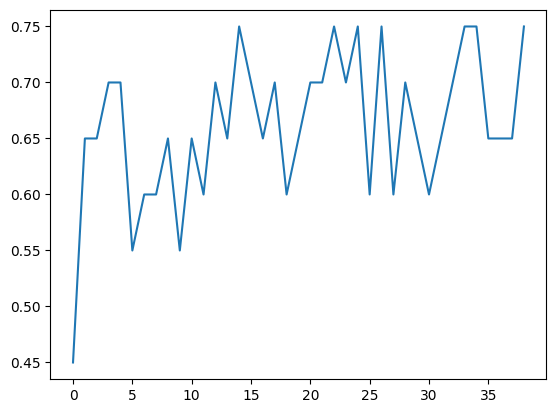

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
import numpy as np

temp = []
for j in range(1,40):
    df_new = pd.read_csv('acdf_cleaned.csv', usecols=feature_names[0:j] + ['AC50'])
    final_df = final_df[final_df['AC50'] < 1200]
    X = df_new.drop(columns=['AC50'])
    y = df_new['AC50']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        

    # Fit the model
    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train)

    # Generate bootstrap samples and make predictions
    n_iterations = 100
    values = pd.concat([X_train, y_train], axis=1)
    predictions = []
    for i in range(n_iterations):
        bootstrap = resample(values, replace=True)
        y_bootstrap = bootstrap[y_train.name]
        X_bootstrap = bootstrap.drop(y_train.name, axis=1)
        tree.fit(X_bootstrap, y_bootstrap)
        y_pred = tree.predict(X_test)
        predictions.append(y_pred)

# Compute the 2.5th and 97.5th percentiles of the predictions
    lower = np.percentile(predictions, 10.5, axis=0)
    upper = np.percentile(predictions, 80.5, axis=0)

    within_interval = (y_test.values >= lower) & (y_test.values <= upper)
    acc = within_interval.mean()
    temp.append(acc)
    print(j , acc)
plt.plot(temp)

# Now `lower` and `upper` are your 95% confidence intervals

In [24]:
df_new

,AMR,ATS6s,AATS6p,AATS2i,AATS5i,AATS7i,ATSC5c,ATSC3v,ATSC5v,ATSC6v,...,JGI10,TDB1u,TDB2u,TDB10m,TDB10e,PPSA-1,PPSA-3,DPSA-1,Du,AC50
0,54.1603,228.877315,1.428454,150.164192,159.763739,154.926707,-0.167843,-887.614748,699.143580,78.620185,...,0.007018,1.327346,2.316783,639.484961,58.087568,385.332309,18.102485,82.876531,1.309972,1190.0
1,51.4622,24.904321,1.360939,151.998655,158.821830,156.443261,-0.070620,-256.965849,-412.341079,412.908354,...,0.005102,1.322255,2.316908,726.907551,77.592298,469.050681,26.657763,220.957792,1.422600,1140.0
2,22.8452,213.888889,1.471832,150.160006,157.602426,158.887699,0.203645,-226.415279,-261.113532,-16.980382,...,0.004598,1.289068,2.245100,587.007758,69.951583,430.229987,23.057339,182.081343,1.426697,1030.0
3,45.8466,23.527778,1.296010,152.204543,159.259827,156.868863,-0.099131,-409.286871,-264.637543,533.479303,...,0.005420,1.307540,2.301283,650.185755,76.973462,486.846952,27.173210,262.228281,1.415445,1000.0
4,58.4512,449.955247,1.318572,157.706262,164.122816,167.759954,0.240984,301.898224,-205.756998,-1064.421997,...,0.007595,1.332692,2.310099,506.465406,58.120319,452.602381,22.560876,227.010021,1.272207,866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,35.7083,304.416667,1.382874,153.197603,164.109119,163.746631,0.035651,-441.115209,106.100723,-288.750479,...,0.009782,1.331175,2.286334,424.044538,68.308513,380.689198,20.385711,179.389579,1.313951,16.0
93,74.6512,521.016461,1.466116,152.939523,159.483032,160.001417,-0.203674,14.046770,-518.719310,-563.084926,...,0.006764,1.338475,2.340390,580.553404,64.054205,475.150279,25.306423,86.971581,1.320353,14.0
94,40.1848,318.194444,1.414844,153.715431,163.367202,159.643614,0.077967,-359.805376,95.046341,-206.815085,...,0.010532,1.325020,2.270442,439.436248,67.391812,412.182388,18.593432,211.988438,1.269191,11.0
95,44.6556,582.861111,1.247007,162.283575,163.934533,163.431569,-0.552359,-570.521819,-70.114596,78.043606,...,0.008214,1.347398,2.335325,681.439936,80.334419,381.129807,26.915241,56.387604,1.216235,11.0


In [25]:
temp[10:20]

[0.65, 0.6, 0.7, 0.65, 0.75, 0.7, 0.65, 0.7, 0.6, 0.65]

In [22]:
from sklearn.utils import resample
import numpy as np
import pandas as pd


df_new = pd.read_csv('acdf_cleaned.csv', usecols=feature_names[0:21] + ['AC50'])
final_df = final_df[final_df['AC50'] < 1200]
X = df_new.drop(columns=['AC50'])
y = df_new['AC50']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        

    # Fit the model
tree = DecisionTreeRegressor(random_state=42) # why I used this algorithm
tree.fit(X_train, y_train)

    # Generate bootstrap samples and make predictions
n_iterations = 100
values = pd.concat([X_train, y_train], axis=1)
predictions = []
for i in range(n_iterations):
    bootstrap = resample(values, replace=True)
    y_bootstrap = bootstrap[y_train.name]
    X_bootstrap = bootstrap.drop(y_train.name, axis=1)

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_bootstrap, y_bootstrap)
    
    y_pred = tree.predict(X_test)
    predictions.append(y_pred)

    dump(tree, fR'tree_reg_models/tree_{i}.joblib')

print("Successfully trained and saved 100 tree models")

# Compute the 10.5th and 80.5th percentiles of the predictions
lower = np.percentile(predictions, 2.5, axis=0)
upper = np.percentile(predictions, 97.5, axis=0)

within_interval = (y_test.values >= lower) & (y_test.values <= upper)
acc = within_interval.mean()
acc
# Now `lower` and `upper` are your 70% confidence intervals

Successfully trained and saved 100 tree models


0.85

In [29]:
X_test.columns

Index(['ATS6s', 'AATS2i', 'AATS5i', 'AATS7i', 'ATSC3v', 'ATSC5v', 'ATSC6v',
       'ATSC2p', 'ATSC4i', 'MATS5s', 'GATS4c', 'GATS5s', 'BCUTp-1l', 'SwHBa',
       'JGI3', 'JGI9', 'JGI10', 'TDB2u', 'TDB10e', 'PPSA-3', 'Du'],
      dtype='object')

In [30]:
X_test.to_csv('X_test.csv', index=False)

In [36]:
import plotly.graph_objects as go

# Create the bar plot
bar = go.Bar(y=list(range(len(lower))), x=upper-lower, base=lower, orientation='h')

# Plot the y_test values
scatter = go.Scatter(y=list(range(len(y_test))), x=y_test, mode='markers', marker=dict(color='red'))

# Create the layout
layout = go.Layout(title='Bar and Scatter Plot at 50% /confidence level', xaxis=dict(title='AC50 Value'), yaxis=dict(title='Index of Test molecules'))

# Create the figure and add the traces
fig = go.Figure(data=[bar, scatter], layout=layout)

# Show the plot
fig.show()

In [33]:
import plotly.graph_objects as go

# Create the bar plot
bar = go.Bar(y=list(range(len(lower))), x=upper-lower, base=lower, orientation='h')

# Plot the y_test values
scatter = go.Scatter(y=list(range(len(y_test))), x=y_test, mode='markers', marker=dict(color='red'))

# Create the layout
layout = go.Layout(title='Bar and Scatter Plot at 75% /confidence level', xaxis=dict(title='AC50 Value'), yaxis=dict(title='Index of Test molecules'))

# Create the figure and add the traces
fig = go.Figure(data=[bar, scatter], layout=layout)

# Show the plot
fig.show()

In [40]:
import plotly.graph_objects as go

# Create the bar plot
bar = go.Bar(y=list(range(len(lower))), x=upper-lower, base=lower, orientation='h')

# Plot the y_test values
scatter = go.Scatter(y=list(range(len(y_test))), x=y_test, mode='markers', marker=dict(color='red'))

# Create the layout
layout = go.Layout(title='Bar and Scatter Plot at 95% /confidence level', xaxis=dict(title='AC50 Value'), yaxis=dict(title='Index of Test molecules'))

# Create the figure and add the traces
fig = go.Figure(data=[bar, scatter], layout=layout)

# Show the plot
fig.show()

In [27]:
final_cols = feature_names[0:21]
final_cols

['AATS5i',
 'JGI3',
 'MATS5s',
 'Du',
 'ATS6s',
 'SwHBa',
 'ATSC3v',
 'BCUTp-1l',
 'ATSC4i',
 'TDB10e',
 'GATS4c',
 'JGI10',
 'AATS2i',
 'ASP-0',
 'ATSC3i',
 'GATS7e',
 'TDB2u',
 'ATSC2p',
 'GATS6c',
 'AMR',
 'FPSA-3']

In [28]:
cols_df = pd.DataFrame(final_cols, columns=['Feature'])

In [ ]:
# cols_df.to_csv('final_cols.csv', index=False)

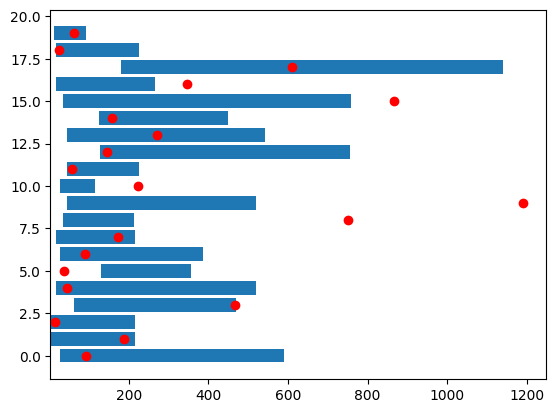

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Create the bar plot
plt.barh(range(len(lower)), upper-lower, left=lower)

# Plot the y_test values
plt.scatter(y_test, range(len(y_test)), color='red')

# Show the plot
plt.show()